##  Initialization

In [1]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import copy
from IPython.display import display


## 1. Consumer-level flexibility models

1A) We first consider that this consumer has a single (fully) flexible load and a rooftop
PV panel. They want to utilize their flexible load and rooftop PV production to
minimize their daily energy procurement cost. Their maximum hourly PV production
is perfectly known, but can be fully curtailed. Their load is fully flexible in each hour,
however, the consumer wants to satisfy a minimum (total) energy consumption at the
end of the day. They can sell/buy electricity to/from the distribution grid at an hourly
electricity price, but must pay an hourly grid tariff fee for all net imports and exports.
We analyze how these cost structures can impact their flexibility and profits.

i) Formulate the optimization problem of this flexible consumer, describing its main
components (input data, decision variables, objective function, constraints) and
properties.



Input data
- $p_t$: electricity price [DKK/kWh]  
- $g_{ti}$: grid tariff import [DKK/kWh]  
- $g_{te}$: grid tariff export [DKK/kWh]  
- $\bar{P}_g$: max PV generation [kWh]  
- $E_{\min}$: minimum daily energy consumption [kWh]  

Decision variables
- $l_t$: flexible load consumption [kWh]  
- $P_g$: PV generation used [kWh]  
- $g^{\text{in}}_t$: grid import [kWh]  
- $g^{\text{out}}_t$: grid export [kWh]  

Objective function

Minimize:  
$$
\sum_{t=1}^{T} \left[ (p_t + g_{ti}) g^{\text{in}}_t - (p_t - g_{te}) g^{\text{out}}_t \right]
$$

Constraints
- $P_g \leq \bar{P}_g$ for all $t$  
- $l_t = g^{\text{in}}_t + P_g - g^{\text{out}}_t$ for all $t$  
- $\sum_{t=1}^{T} l_t \geq E_{\min}$  
- $l_t \geq 0$, $P_g \geq 0$, $g^{\text{in}}_t \geq 0$, $g^{\text{out}}_t \geq 0$ for all $t$  


ii) Formulate the dual problem, Lagrangian, and KKT conditions of this optimization
problem. Describe their properties.

iii) Without numerically solving this optimization problem, analyze its structure and
discuss qualitatively the characteristics of its optimal solutions. Which cost com-
ponents and constraints have the most impact on the solutions? Which constraint
are binding at optimality? How does the input data impact the optimal solutions?
In particular, compare the cases in which: the electricity prices and grid tariffs
are constant through the day or vary hourly. For which values of the cost compo-
nents, can you conclude that this optimization problem is equivalent to a simpler
optimization one? Tip: you can use the dual formulation and KKT conditions to
motivate your analysis

iv) Implement this optimization problem in a programming language of your choice.
Provide a well-documented working code.

Set parameter Username
Set parameter LicenseID to value 2706891
Academic license - for non-commercial use only - expires 2026-09-10
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 49 rows, 96 columns and 144 nonzeros
Model fingerprint: 0x27176a20
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [2e-01, 2e+01]
Presolve removed 33 rows and 42 columns
Presolve time: 0.02s
Presolved: 16 rows, 54 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0800000e+03   1.499706e+04   0.000000e+00      0s
       5    1.4377500e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.03 seconds

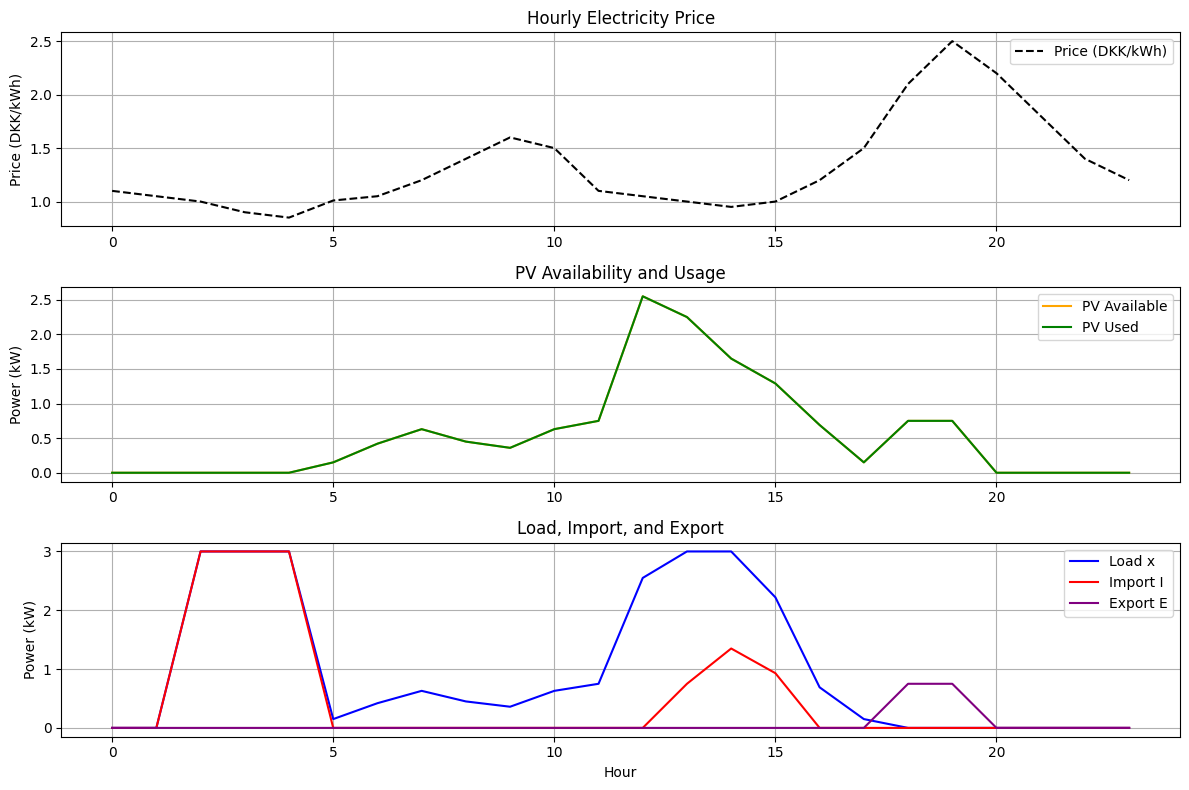

In [2]:
#!/usr/bin/env python3
"""
Solve the consumer flexibility LP with Gurobi.

- Reads JSON files if present in data/assignment1/ (appliance_params.json, bus_params.json,
  consumer_params.json, DER_production.json, usage_preference.json). If files are not found,
  it falls back to embedded JSONs (the ones you provided).

- Model:
    x_t : flexible load consumed [kWh] (0..3 kWh)
    u_t : PV used locally [kWh] (<= available PV)
    I_t : grid import [kWh]
    E_t : grid export [kWh]
  Objective: minimize total cost = sum_t ((price_t + import_tariff)*I_t - (price_t - export_tariff)*E_t)
  Constraint: sum_t x_t >= 24 kWh  (8 equivalent hours * 3 kWh/h)

Requires: gurobipy
Run: python solve_consumer_lp_gurobi.py
"""

import json
from pathlib import Path
import sys

# Try importing gurobipy
try:
    import gurobipy as gp
    from gurobipy import GRB
except Exception as e:
    sys.exit("gurobipy is required to run this script. Import error: %s" % e)

"""
# -------------------------
# Embedded JSONs (fallback)
# -------------------------
embedded_appliance_params = {
  "DER": [
    {
      "DER_id": "PV_01",
      "DER_type": "PV",
      "max_power_kW": 3.0,
      "min_power_ratio": 0.0,
      "max_ramp_rate_up_ratio": 1.0,
      "max_ramp_rate_down_ratio": 1.0
    }
  ],
  "load": [
    {
      "load_type": "fully flexible load",
      "load_id": "FFL_01",
      "max_load_kWh_per_hour": 3.0,
      "min_load_ratio": 0.0,
      "max_ramp_rate_up_ratio": 1.0,
      "max_ramp_rate_down_ratio": 1.0,
      "min_on_time_h": 0,
      "min_off_time_h": 0
    }
  ],
  "storage": None,
  "heat_pump": None
}

embedded_bus_params = [ {
  "bus_ID": "Bus1",
  "import_tariff_DKK/kWh": 0.5,
  "export_tariff_DKK/kWh": 0.4,
  "max_import_kW": 1000,
  "max_export_kW": 500,
  "penalty_excess_import_DKK/kWh": 10,
  "penalty_excess_export_DKK/kWh": 10,
  "energy_price_DKK_per_kWh": [
    1.1,1.05,1.0,0.9,0.85,1.01,1.05,1.2,1.4,1.6,1.5,1.1,1.05,1.0,0.95,1.0,1.2,1.5,2.1,2.5,2.2,1.8,1.4,1.2
  ]
} ]

embedded_consumer_params = [
  {
    "consumer_id":"C1",
    "connection_bus":"Bus1",
    "list_appliances":["PV_01","FFL_01"]
  }
]

embedded_DER_production = [
    {
        "consumer_ID": "C1",
        "DER_type": "solar",
        "hourly_profile_ratio": [
            0.0,0.0,0.0,0.0,0.0,0.05,0.14,0.21,0.15,0.12,0.21,0.25,0.85,0.75,0.55,0.43,0.23,0.05,0.25,0.25,0.0,0.0,0.0,0.0
        ]
    }
]

embedded_usage_preference = [
    {"consumer_ID": "C1",
    "grid_preferences": None,
    "DER_preferences": None,
    "load_preferences":[
        {
            "load_id": "FFL_01",
            "min_total_energy_per_day_hour_equivalent": 8,
            "max_total_energy_per_day_hour_equivalent": None,
            "hourly_profile_ratio": None
        }
    ],
    "storage_preferences": None,
    "heat_pump_preferences": None}
]
"""
# -------------------------
# Utility to load JSON or fallback
# -------------------------
def try_load_json(path: Path):
    if path.exists():
        return json.loads(path.read_text())
    return None


# Paths (change if needed)
base_folder = Path("data/question_1a/")
appliance_path = base_folder / "appliance_params.json"
bus_path = base_folder / "bus_params.json"
consumer_path = base_folder / "consumer_params.json"
der_prod_path = base_folder / "DER_production.json"
usage_pref_path = base_folder / "usage_preference.json"

appliance_params = try_load_json(appliance_path)
bus_params = try_load_json(bus_path)
consumer_params = try_load_json(consumer_path)
DER_production = try_load_json(der_prod_path)
usage_pref = try_load_json(usage_pref_path)

# Single consumer / bus assumption for this assignment
consumer = consumer_params[0]
bus = bus_params[0]

# Extract specs
pv_spec = appliance_params["DER"][0]
pv_max_kW = float(pv_spec["max_power_kW"])

load_spec = appliance_params["load"][0]
load_max_kWh = float(load_spec["max_load_kWh_per_hour"])

prices = bus["energy_price_DKK_per_kWh"]
if len(prices) != 24:
    raise SystemExit("Expected 24 hourly prices; got %d" % len(prices))

import_tariff = float(bus["import_tariff_DKK/kWh"])
export_tariff = float(bus["export_tariff_DKK/kWh"])
max_import = float(bus["max_import_kW"])
max_export = float(bus["max_export_kW"])

der_profile = DER_production[0]["hourly_profile_ratio"]
if len(der_profile) != 24:
    raise SystemExit("Expected 24 hourly DER profile entries")

pv_avail = [pv_max_kW * float(r) for r in der_profile]

# daily minimum energy (8 equivalent hours * 3 kWh/h)
min_equivalent_hours = usage_pref[0]["load_preferences"][0]["min_total_energy_per_day_hour_equivalent"]
E_min = float(min_equivalent_hours) * load_max_kWh

T = list(range(24))

# Build model
m = gp.Model("consumer_flex_lp")
m.setParam('OutputFlag', 1)

# Variables
x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
u = m.addVars(T, lb=0.0, name="u")          # cap by constraints
I = m.addVars(T, lb=0.0, ub=max_import, name="I")
E = m.addVars(T, lb=0.0, ub=max_export, name="E")

# PV availability constraints
for t in T:
    m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")

# Energy balance
for t in T:
    m.addConstr(I[t] - E[t] + u[t] == x[t], name=f"balance_{t}")

# Daily minimum
daily_min_con = m.addConstr(gp.quicksum(x[t] for t in T) >= E_min, name="daily_min_energy")

# Objective
obj = gp.quicksum((prices[t] + import_tariff) * I[t] - (prices[t] - export_tariff) * E[t] for t in T)
m.setObjective(obj, GRB.MINIMIZE)

# Optimize
m.optimize()

if m.status != GRB.OPTIMAL:
    print("Optimization status:", m.status)

# Results
x_sol = [x[t].X for t in T]
u_sol = [u[t].X for t in T]
I_sol = [I[t].X for t in T]
E_sol = [E[t].X for t in T]

total_import = sum(I_sol)
total_export = sum(E_sol)
total_load = sum(x_sol)
total_pv_used = sum(u_sol)
objective_value = m.ObjVal
shadow_daily_min = daily_min_con.Pi

print("\nHourly schedule (hours 0..23):")
print(" t | price | pv_avail | x (load) | u (pv used) | import I | export E")
for t in T:
    print(f"{t:2d} | {prices[t]:5.2f} | {pv_avail[t]:7.3f} | {x_sol[t]:7.3f} | {u_sol[t]:10.3f} | {I_sol[t]:8.3f} | {E_sol[t]:8.3f}")

print("\nTotals:")
print(f" Total load (sum x):        {total_load:.3f} kWh")
print(f" Total PV used (sum u):     {total_pv_used:.3f} kWh")
print(f" Total import (sum I):      {total_import:.3f} kWh")
print(f" Total export (sum E):      {total_export:.3f} kWh")
print(f" Objective (total cost):    {objective_value:.3f} DKK")
print(f" Shadow price (daily min):  {shadow_daily_min:.3f} DKK per kWh")

# Print binding constraints
print("\nBinding constraints (tight):")
for constr in m.getConstrs():
    if abs(constr.Slack) < 1e-6:
        print(f" {constr.ConstrName} is binding. Dual: {constr.Pi:.6f}")


# Plot schedule
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(T, prices, label="Price (DKK/kWh)", color='black', linestyle='--')
plt.ylabel("Price (DKK/kWh)")
plt.title("Hourly Electricity Price")
plt.grid()
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(T, pv_avail, label="PV Available", color='orange')
plt.plot(T, u_sol, label="PV Used", color='green')
plt.ylabel("Power (kW)")
plt.title("PV Availability and Usage")
plt.grid()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(T, x_sol, label="Load x", color='blue')
plt.plot(T, I_sol, label="Import I", color='red')
plt.plot(T, E_sol, label="Export E", color='purple')
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Load, Import, and Export")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


v) Construct relevant scenarios of system-level cost structures based on the data pro-
vided, solve this optimization problem over these scenarios, analyze its optimal
solutions (primal and dual) and answer the following question: How do cost struc-
tures impact the consumers flexibility and profits? Present your insights in a
compact manner using adequate visual aids. Do these solutions align with your
analysis from Question 1.(a).iii.?